## Compiling Food and Agriculture Organization (FAO) Crop Data

In [1]:
import os, sys, json
from fnmatch import fnmatch
from itertools import product, compress, chain
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import geopandas as gpd
import plotly
import plotly.graph_objects as go
import plotly.express as px
import pycountry

### Food and Agriculture Organization of the United Nations
- [Global Agro-Ecological Zoning version 4 (GAEZ v4)](https://gaez.fao.org/)
- [Global Spatial Database of National and Sub-National Agricultural Land-Use Statistics (AgroMaps)](https://gaez.fao.org/pages/agromaps)
- [FAO STAT](https://www.fao.org/faostat/en/#home)
- [FAO Map Catalog](https://data.apps.fao.org/map/catalog/srv/eng/catalog.search#/home)
- The [FAO Data Lab](https://www.fao.org/datalab/website/web/home) validated their subnational data with HandInHand (HIH) data from some countries [link](https://www.fao.org/datalab/website/web/agricultural-production-data-national-and-sub-national-level).
  - Burkina Faso (1995-2018) admin-1 and admin-2 data used
  - Ethiopia (2008-2019) admin-1 data used
  - Zaimbabwe (2012 and 2015) admin-1 data used
  


### Read UN Central Product Classification (CPC)
- [UN > Staistics Division > Classfications on economic statistics](https://unstats.un.org/unsd/classifications/Econ)
- [Definitions and standards used in FAOSTAT](https://www.fao.org/faostat/en/#definitions)

In [2]:
# UN Central Product Classification (CPC)
# https://unstats.un.org/unsd/classifications/Econ/cpc
# fn = 'https://unstats.un.org/unsd/classifications/Econ/Download/In%20Text/CPC_Ver_2_1_english_structure.txt'
fn = '../data/fao/CPC_Ver_2_1_english_structure.txt'
cpc2 = pd.read_csv(fn, dtype=str, encoding='latin-1')
cpc2 = cpc2.rename(columns={'CPC21code':'code','CPC21title':'product'}).set_index('code')
dict_cpc2_name = cpc2.to_dict()['product']

### FAO AgroMaps Shapefiles
- Data is obtained manually from [Global Spatial Database of National and Sub-National Agricultural Land-Use Statistics (AgroMaps)](https://gaez.fao.org/pages/agromaps).

In [3]:
# FAO AgroMaps Shapefiles ============================ #
# Read all shapefiles in the sub directories --------- #
dir_agromaps = '../data/fao_agromaps/'
list_files = []
for path, subdirs, files in os.walk(dir_agromaps):
    for name in files: 
        if fnmatch(name.lower(), '*.shp'): 
            list_files.append(os.path.join(path, name))
# Concat all dataframes
dict_cols = {
    'CNTCODE_':'CNTCODE',
    'CNTCODEOR':'UNCODEOR',
    'COUNTRY_NA':'COUNTRY',
    'NAME1_':'NAME1',
    'NAME_1':'NAME1',
    'NAME2_':'NAME2',
    'COMMENTS_':'COMMENTS'
}
container = []
for filn in list_files:
    df = gpd.read_file(filn)
    if df.columns.isin(['CNT_PCODE']).any():
        df = df.drop(columns=['CNT_PCODE'])
    df = df.rename(columns=dict_cols)
    if df.shape[1] == 8:
        df['adm_level'] = 1
    elif df.shape[1] == 10:
        df['adm_level'] = 2
    else:
        raise ValueError('Invalid size of a DataFrame.')
    # Touch CRS
    if df.crs == None:
        df = df.set_crs('epsg:4326')
    else:
        df = df.to_crs('epsg:4326')
    container.append(df)
df = pd.concat(container, axis=0)
# ---------------------------------------------------- #
# Côte d'Ivoire: FAO AgroMaps does not include CIV.shp in the zipped file
# Temporarily, we bring the geometry from GADM.
fao_civ = gpd.read_file('../data/fao_agromaps/CIV/AgroMaps/Africa/shapefiles/CIV/admin1/CIV.DBF')
gadm = gpd.read_file('/Users/dlee/data/gis/world_country/world_countries_GADM/world_countries_gadm_v1/gadm_v1_lev2.shp')
gadm_civ = gadm[gadm['ISO'] == 'CIV'].reset_index()
gadm_civ['NAME_2'] = gadm_civ['NAME_2'].map(lambda x:x.replace('é','e'))
gadm_civ['NAME_2'] = gadm_civ['NAME_2'].replace({'Agnibilekrou':'Agnibilekro','Mbahiakro':"M'bahiakro"})
name_mismatch = gadm_civ[~gadm_civ['NAME_2'].isin(fao_civ['NAME1_'])]
assert len(name_mismatch) == 0
df_civ = fao_civ.drop(columns=['geometry']).merge(gadm_civ[['NAME_2','geometry']], left_on='NAME1_', right_on='NAME_2').drop(columns='NAME_2')
df = pd.concat([df, df_civ], axis=0)
# ---------------------------------------------------- #

# Set NaN values to "none" values -------------------- #
df.loc[df['COMMENTS'].isna(),'COMMENTS'] = 'none'
df.loc[df['NAME2'].isna(),'NAME2'] = 'none'
df.loc[df['DCODE'].isna(),'DCODE'] = 'none'
# ---------------------------------------------------- #

# Manual Correction ---------------------------------- #
# Country and PCODE
rdx = df['PCODE'].map(lambda x:x[:3] == 'AGR')
df.loc[rdx,'PCODE'] = df.loc[rdx,'PCODE'].map(lambda x:'ARG'+x[3:])
df.loc[df['CNTNAME3'] == 'PRC', 'CNTNAME3'] = 'COG'
df.loc[df['CNTNAME3'] == 'DRC', 'CNTNAME3'] = 'COD'
df.loc[df['PCODE'] == 'TT0002', 'PCODE'] = 'TTO002'
df.loc[df['PCODE'] == 'TT0003', 'PCODE'] = 'TTO003'
assert len(df[df['PCODE'].map(lambda x:x[:3]) != df['CNTNAME3']]) == 0
# PCODE and DECODE
df.loc[df['PCODE'] == 'BRA0022', 'PCODE'] = 'BRA022'
assert all(np.unique([len(c) for c in df['PCODE'].unique()]) == 6)
df.loc[df['DCODE'] == 'MEX01610', 'DCODE'] = 'MEX016010'    # typo
df.loc[df['DCODE'] == 'MEX0290122', 'DCODE'] = 'MEX029022'    # typo
df.loc[df['DCODE'] == 'BRA010115\r\n', 'DCODE'] = 'BRA010115'    # typo
df.loc[df['DCODE'] == 'BRA010103\r\n', 'DCODE'] = 'BRA010103'    # typo
df.loc[df['DCODE'] == 'BRA005356\r\n', 'DCODE'] = 'BRA005356'    # typo
df.loc[df['DCODE'] == 'BRA009157\r\n', 'DCODE'] = 'BRA009157'    # typo
df.loc[df['DCODE'] == 'BRA009100\r\n', 'DCODE'] = 'BRA009100'    # typo
df.loc[df['DCODE'] == 'BRA013558\r\n', 'DCODE'] = 'BRA013558'    # typo
assert all(np.unique([len(a) for a in np.unique(df['DCODE'])]) == [4, 9])
rdx = df['DCODE'].map(lambda x:x[:3] == 'AGR')
df.loc[rdx,'DCODE'] = df.loc[rdx,'DCODE'].map(lambda x:'ARG'+x[3:])
df.loc[df['DCODE'] == 'MEX016072', 'PCODE'] = 'MEX016'
df.loc[df['DCODE'] == 'MEX010001', 'PCODE'] = 'MEX010'
df.loc[df['DCODE'] == 'HND004017', 'PCODE'] = 'HND004'
df.loc[df['DCODE'] == 'HND001317', 'DCODE'] = 'HND013017'
df_admin2 = df[df['adm_level']==2]
assert all(df_admin2['PCODE'] == df_admin2['DCODE'].map(lambda x:x[:6]))
# ---------------------------------------------------- #

# Reset Country ISO code and Name -------------------- #
# We are using "pycountry"
country_iso3 = df['CNTNAME3'].unique()
country_name = [pycountry.countries.get(alpha_3=code).name for code in country_iso3]
dict_country = {k:v for k, v in zip(country_iso3, country_name)}
country_iso2 = [pycountry.countries.get(alpha_3=code).alpha_2 for code in country_iso3]
dict_country_iso2 = {k:v for k, v in zip(country_iso3, country_iso2)}
df['country'] = df['CNTNAME3'].replace(dict_country)
df['cnt_iso2'] = df['CNTNAME3']
df['cnt_iso2'] = df['cnt_iso2'].replace(dict_country_iso2)
# ---------------------------------------------------- #

# Unified geocode and names -------------------------- #
df['UCODE'] = df['DCODE'].copy()
df.loc[df['UCODE'] == 'none', 'UCODE'] = df.loc[df['UCODE'] == 'none', 'PCODE']
df['UNAME'] = df['NAME2'].copy()
df.loc[df['UNAME'] == 'none', 'UNAME'] = df.loc[df['UNAME'] == 'none', 'NAME1']
# ---------------------------------------------------- #

# Final Processing ----------------------------------- #
dict_col = {
    'country':'cnt_name',
    'CNTNAME3':'cnt_iso3',
    'NAME1':'adm1_name',
    'NAME2':'adm2_name',
    'UNAME':'admx_name',
    'COMMENTS':'comments',
    'PCODE':'adm1_code',
    'DCODE':'adm2_code',
    'UCODE':'admx_code'
}
df = df.rename(columns=dict_col)
final_cols = [
    'cnt_name','cnt_iso2','cnt_iso3',
    'adm1_code','adm1_name','adm2_code','adm2_name',
    'adm_level','admx_code','admx_name',
    'geometry','comments'
]
df = df[final_cols]

# Final touch 
df[df == 'none'] = np.nan
df = df.drop_duplicates().reset_index(drop=True).set_crs('epsg:4326')

# Some countries don't have adm1 shapefile. We generate this by dissolving polygons
country_no_adm1 = ['Benin', 'Egypt']
container = []
for country in country_no_adm1:
    temp = df[df['cnt_name'] == country]
    if country == 'Benin': 
        temp.loc[:,'geometry'] = temp['geometry'].simplify(0.01)
    temp = temp.dissolve('adm1_code').reset_index()[final_cols]
    temp['adm_level'] = 1
    temp[['adm2_code','adm2_name']] = np.nan
    temp[['admx_code','admx_name']] = temp[['adm1_code','adm1_name']].values
    container.append(temp)
df_adm1_restored = pd.concat(container, axis=0)
df = pd.concat([df, df_adm1_restored], axis=0).reset_index(drop=True)
# ---------------------------------------------------- #

# Save shapefiles ------------------------------------ #
df['geometry'] = df['geometry'].simplify(0.001)
# All data
fn = '../data/shapefile/fao_adm_all.shp'
df.to_file(fn); print(f'{fn} is saved.')
# Admin-1 level
fn = '../data/shapefile/fao_adm1.shp'
df_adm1 = df[df['adm_level'] == 1].reset_index(drop=True)
df_adm1.to_file(fn); print(f'{fn} is saved.')
# Admin-2 level
fn = '../data/shapefile/fao_adm2.shp'
df_adm2 = df[df['adm_level'] == 2].reset_index(drop=True)
df_adm2.to_file(fn); print(f'{fn} is saved.')
# Admin-X level
fn = '../data/shapefile/fao_admx.shp'
list_adm2 = df.loc[df['adm_level'] == 2, 'cnt_iso3'].unique()
list_adm1 = df.loc[~df['cnt_iso3'].isin(list_adm2), 'cnt_iso3'].unique()
df_admx = pd.concat([df[df['cnt_iso3'].isin(list_adm1)],df[df['cnt_iso3'].isin(list_adm2)]],axis=0).reset_index(drop=True)
df_admx.to_file(fn); print(f'{fn} is saved.')
# ==================================================== #
df.head()

../data/shapefile/fao_adm_all.shp is saved.
../data/shapefile/fao_adm1.shp is saved.
../data/shapefile/fao_adm2.shp is saved.
../data/shapefile/fao_admx.shp is saved.


,cnt_name,cnt_iso2,cnt_iso3,adm1_code,adm1_name,adm2_code,adm2_name,adm_level,admx_code,admx_name,geometry,comments
0,United States,US,USA,USA001,Alabama,NaN,NaN,1.0,USA001,Alabama,"POLYGON ((-88.18916 34.99805, -88.19554 35.011...",NaN
1,United States,US,USA,USA002,Alaska,NaN,NaN,1.0,USA002,Alaska,"MULTIPOLYGON (((-132.99482 55.61432, -132.9708...",NaN
2,United States,US,USA,USA003,Arizona,NaN,NaN,1.0,USA003,Arizona,"POLYGON ((-114.71909 32.71846, -114.70111 32.7...",NaN
3,United States,US,USA,USA004,Arkansas,NaN,NaN,1.0,USA004,Arkansas,"POLYGON ((-91.17778 33.39249, -91.12389 33.270...",NaN
4,United States,US,USA,USA005,California,NaN,NaN,1.0,USA005,California,"MULTIPOLYGON (((-120.61827 34.64876, -120.6019...",NaN


### FAO AgroMaps Subnational Crop Data
- Data is obtained manually from [Global Spatial Database of National and Sub-National Agricultural Land-Use Statistics (AgroMaps)](https://gaez.fao.org/pages/agromaps).

In [21]:
# FAO AgroMaps Shapefiles ============================ #
# Read all dbf files in the sub directories ---------- #
dir_agromaps = '../data/fao_agromaps/'
list_files = []
for path, subdirs, files in os.walk(dir_agromaps):
    for name in files: 
        if fnmatch(name.lower(), '*.dbf'): 
            list_files.append(os.path.join(path, name))
# Exclude shapfiles' dbf files
list_files = [fn for fn in list_files if fn.find('shapefile') == -1]
# Concat all dataframes
container = []
for filn in list_files:
    df = gpd.read_file(filn)
    if df.shape[1] == 9:
        df['adm_level'] = 1
    elif df.shape[1] == 10:
        df['adm_level'] = 2
    else:
        raise ValueError('Invalid size of a DataFrame.')
    container.append(df)
df = pd.concat(container, axis=0)
# Remove missing and negative values
rdx = (df['DATA'].isna()) | (df['DATA'] == -999.0) | (df['DATA'] < 0)
df = df[~rdx]
# ---------------------------------------------------- #

# Reset Country ISO code and Name -------------------- #
df['cnt_iso3'] = df['CODE'].map(lambda x: x[:3])
df = df[df['cnt_iso3'] != 'N.A']
df['cnt_name'] = df['cnt_iso3']
df['cnt_iso2'] = df['cnt_iso3']
country_iso3 = df['cnt_iso3'].unique()
country_name = [pycountry.countries.get(alpha_3=code).name for code in country_iso3]
dict_country = {k:v for k, v in zip(country_iso3, country_name)}
country_iso2 = [pycountry.countries.get(alpha_3=code).alpha_2 for code in country_iso3]
dict_country_iso2 = {k:v for k, v in zip(country_iso3, country_iso2)}
df['cnt_name'] = df['cnt_name'].replace(dict_country)
df['cnt_iso2'] = df['cnt_iso2'].replace(dict_country_iso2)
# Code validation
assert all(np.unique([len(c) for c in df['CODE'].unique()]) == [6,9]) == True
# ---------------------------------------------------- #

# Product and Indicator name ------------------------- #
# Indicator
dict_element = {
    '031':'Harvested Area',
    '041':'Yield',
    '051':'Production',
    '061':'Planted Area',
    '31':'Harvested Area',
    '41':'Yield',
    '51':'Production',
    '61':'Planted Area',
}
df['ELEMENT_CO'] = df['ELEMENT_CO'].replace(dict_element)
# Link FAO Item Code to CPC2 code
df_std = pd.read_csv('../data/fao_stat/definitions_and_standards_FAOSTAT.csv')
df_std = df_std[['Item Code','Item','CPC Code','Description']].drop_duplicates().rename(columns={'Item Code':'Code'})
df_std = df_std.rename(columns={'CPC Code':'cpc2_code'})
df_item = pd.read_excel('../data/fao_agromaps/ZAF/Lookup_table.xls',skiprows=1,dtype=str)
df_item = df_item.merge(df_std, on='Code')
dict_item_name = df_item.set_index('Code').to_dict()['Name']
dict_item_cpc2 = df_item.set_index('Code').to_dict()['cpc2_code']
df['ITEM_CODE'] = df['ITEM_CODE'].astype(int).astype(str)
df['ITEM_CODE'] = df['ITEM_CODE'].replace({'46':'461'})   # Some erros are found in Brazil
df['product'] = df['ITEM_CODE'].replace(dict_item_name)
df['cpc2_raw'] = df['ITEM_CODE'].replace(dict_item_cpc2)
df['cpc2_raw'] = df['cpc2_raw'].replace({'F2041':'23320'})
# CPC2 Code with sub-headings
cpc2_sh = df.loc[~df['cpc2_raw'].isin(cpc2.index),'cpc2_raw'].unique()
dict_cpc2 = {k:v for k,v in zip(cpc2_sh, [c[:5] for c in cpc2_sh])}
df['cpc2_code'] = df['cpc2_raw'].replace(dict_cpc2)
# CPC2 Names
df['cpc2_name'] = df['cpc2_code'].map(lambda x:dict_cpc2_name[x])
# ---------------------------------------------------- #

# Control other columns ------------------------------ #
df.loc[df['NAME2'].isna(), 'NAME2'] = 'none'
df.loc[df['COMMENTS'].isna(), 'COMMENTS'] = 'none'
dict_cols = {
    'NAME1':'adm1_name',
    'NAME2':'adm2_name',
    'ITEM_CODE':'item_code',
    'ELEMENT_CO':'indicator',
    'CODE':'admx_code',
    'YEAR':'year',
    'DATA':'value',
    'COMMENTS':'comments'
}
df = df.rename(columns=dict_cols)
df['year'] = df['year'].astype(int)
# Specify administrative codes and names
df['adm1_code'] = df['admx_code'].map(lambda x:x[:6])
df.loc[df['adm_level'] == 2, 'adm2_code'] = df.loc[df['adm_level'] == 2, 'admx_code']
df['admx_name'] = df['adm1_name'].copy()
df.loc[df['adm_level'] == 2, 'admx_name'] = df.loc[df['adm_level'] == 2, 'adm2_name']
# Validation of administrative codes
df_adm2 = df[df['adm_level'] == 2]
assert all(df_adm2['adm2_code'].map(lambda x:x[:6]) == df_adm2['adm1_code']) == True
# Final touch
final_cols = [
    'cnt_name','cnt_iso2','cnt_iso3',
    'adm1_code','adm1_name','adm2_code','adm2_name',
    'adm_level','admx_code','admx_name',
    'cpc2_code','cpc2_name','cpc2_raw','product',
    'year','indicator','value','comments'
]
df = df[final_cols]
df[df == 'none'] = np.nan
df = df.drop_duplicates().reset_index(drop=True)

# Validation with shapefile ..... -------------------- #

# ---------------------------------------------------- #

# Save shapefiles ------------------------------------ #
df.to_csv('../data/crop/adm_fao_agromaps.csv')
# ==================================================== #
df.head()

,cnt_name,cnt_iso2,cnt_iso3,adm1_code,adm1_name,adm2_code,adm2_name,adm_level,admx_code,admx_name,cpc2_code,cpc2_name,cpc2_raw,product,year,indicator,value,comments
0,United States,US,USA,USA003,Arizona,NaN,NaN,1,USA003,Arizona,0115,Barley,0115,Barley,1970,Harvested Area,56658.00,NaN
1,United States,US,USA,USA003,Arizona,NaN,NaN,1,USA003,Arizona,0115,Barley,0115,Barley,1970,Yield,4.09,NaN
2,United States,US,USA,USA003,Arizona,NaN,NaN,1,USA003,Arizona,0115,Barley,0115,Barley,1970,Production,231654.10,NaN
3,United States,US,USA,USA005,California,NaN,NaN,1,USA005,California,0115,Barley,0115,Barley,1970,Harvested Area,457311.00,NaN
4,United States,US,USA,USA005,California,NaN,NaN,1,USA005,California,0115,Barley,0115,Barley,1970,Yield,2.80,NaN


In [22]:
# Validation with FAO AgroMaps Shapefile
shape = gpd.read_file('../data/shapefile/fao_adm_all.shp')
# Admin-1 level validation
# There are some inconsistency between FAO AgroMaps and Shapefiles
# (1) Brazil: "Distrito Federal (BRA007)" is not in the shapefile
# (2) Jordan: Irbid (JOR009), Jarash (JOR10), Ma-an (JOR011), Madaba (JOR012) are not in the shapefile
# (3) Egypt: Unknown (EGY???)
# (4) Cameroon: Sud-Ouest (CMR011) is not in the shapefile
temp = df[~df['adm1_code'].isin(shape['adm1_code'])]
# temp[['cnt_name','cnt_iso3','adm1_code','adm1_name']].drop_duplicates()
rdx_adm1 = df['adm1_code'].isin(temp['adm1_code'])
# Admin-2 level validation
temp = df[df['adm_level'] == 2]
temp = temp[~temp['adm2_code'].isin(shape['adm2_code'])]
temp[['cnt_name','cnt_iso3','adm1_code','adm1_name','adm2_code','adm2_name']].drop_duplicates()
### lagged adm2_code in Mexico between data and shapefile...

,cnt_name,cnt_iso3,adm1_code,adm1_name,adm2_code,adm2_name
5357,United States,USA,USA042,South Dakota,USA042???,Washabaugh
69600,United States,USA,USA029,Nevada,USA029???,Ormsby
144040,Brazil,BRA,BRA002,Alagoas,BRA002001,Agua_Branca
144078,Brazil,BRA,BRA002,Alagoas,BRA002006,Barra_de_Sao_Miguel
144083,Brazil,BRA,BRA002,Alagoas,BRA002007,Batalha
...,...,...,...,...,...,...
552186,Mexico,MEX,MEX019,Nuevo Leon,MEX019001,Abasolo
552953,Mexico,MEX,MEX021,Puebla,MEX021051,Coxcatlan
558720,Mexico,MEX,MEX030,Veracruz,MEX030189,Tomatlan
559661,Mexico,MEX,MEX032,Zacatecas,MEX032036,Ojocaliente


In [25]:
sub = df.loc[
    (df['cnt_name'] == 'South Africa') &
    (df['indicator'] == 'Production') &
    (df['adm_level'] == 1) &
    (df['product'] == 'Maize')
]
sub.groupby('year')['value'].sum()

year
1990     8134552.0
1991     7614420.0
1992     2800639.0
1993     9143718.0
1994    11238257.0
1995     4168131.0
1996     9385604.0
1998     5145897.9
Name: value, dtype: float64

In [26]:
sub = df.loc[
    (df['cnt_name'] == 'South Africa') &
    (df['indicator'] == 'Production') &
    (df['adm_level'] == 2) &
    (df['product'] == 'Maize')
]
sub.groupby('year')['value'].sum()

year
1990     8495350.0
1991     8029138.0
1992     3081598.0
1993     9579347.0
1994    11766499.0
1995     4384589.0
1996     9840928.0
Name: value, dtype: float64

### FAO STAT National Crop Production Data
- Data is obtained manually from [FAO STAT > Data > Crops and livestock product](https://www.fao.org/faostat/en/#data/QCL).
- Data flags
  - A: Official figure
  - E: Estimated value
  - I: Imputed value
  - M: Missing value (data cannot exist; not applicable)
  - T: Unofficial figure

In [28]:
# ==================================================== #
# Read a CVS file ------------------------------------ #
def countrycode(cm49):
    try:
        pcnt = pycountry.countries.get(numeric=cm49)
        return pcnt.alpha_3
    except:
        return np.nan
fn = '../data/fao_stat/Production_Crops_Livestock_E_All_Data.csv'
df = pd.read_csv(fn,encoding='latin-1')
df['m49'] = df['Area Code (M49)'].map(lambda x: x[1:])
df['cnt_iso3'] = df['m49'].map(lambda x: countrycode(x))
df = df[df['cnt_iso3'].notna()]
df['cnt_name'] = df['cnt_iso3'].map(lambda x:pycountry.countries.get(alpha_3=x).name)
# Year and Flag
year = [col for col in df.columns if col[1:5].isdigit() & (len(col) == 5)]
year_int = [int(y[1:]) for y in year]
dict_year_int = {k:v for k, v in zip(year, year_int)}
flag = [col for col in df.columns if col[1:5].isdigit() & (len(col) == 6)]
df = df.rename(columns={'Item':'product','Element':'indicator','Unit':'unit',**dict_year_int})
dict_flag_year = {k:v for k,v in zip(flag,year_int)}
# ---------------------------------------------------- #

# Select only crops ---------------------------------- #
# Using indicators
df = df[df['indicator'].isin(['Area harvested', 'Yield', 'Production'])]
df = df[df['unit'].isin(['ha', 'hg/ha', 'tonnes'])]
# Using CPC2 code
# "01": "Products of agriculture, horticulture and market gardening"
df['cpc2_raw'] = df['Item Code (CPC)'].map(lambda x: x[1:])
df = df[df['cpc2_raw'].map(lambda x:x.startswith("01"))]
# ---------------------------------------------------- #

# Control CPC2 Code ---------------------------------- #
# CPC2 Code with sub-headings
cpc2_sh = df.loc[~df['cpc2_raw'].isin(cpc2.index),'cpc2_raw'].unique()
dict_cpc2 = {k:v for k,v in zip(cpc2_sh, [c[:5] for c in cpc2_sh])}
df['cpc2_code'] = df['cpc2_raw'].replace(dict_cpc2)
# CPC2 Names
df['cpc2_name'] = df['cpc2_code'].replace(dict_cpc2_name)
# ---------------------------------------------------- #

# Stacking ------------------------------------------- #
cols_final = [
    'cnt_name','cnt_iso3',
    'cpc2_code','cpc2_name','cpc2_raw','product',
    'indicator'
]
df1 = df[[*cols_final,*year_int]]
df1 = df1.set_index(cols_final).stack().rename('value').reset_index().rename(columns={'level_7':'year'})
# Change unit of "Yield" from hg/ha to mt/ha
df1.loc[df1['indicator']=='Yield','value'] /= 10000
# Flag
df2 = df[[*cols_final,*flag]]
df2 = df2.rename(columns=dict_flag_year)
df2 = df2.set_index(cols_final).stack().rename('value').reset_index().rename(columns={'level_7':'year'})
merged = df1.merge(df2.rename(columns={'value':'flag'}),on=[*cols_final,'year'])
merged = merged.drop_duplicates().reset_index(drop=True)
# ---------------------------------------------------- #

# Save CSV file -------------------------------------- #
fn = '../data/crop/adm_fao_stat.csv'
merged.to_csv(fn); print(f'{fn} is saved.')
# ==================================================== #
merged.head()

../data/crop/adm_fao_stat.csv is saved.


,cnt_name,cnt_iso3,cpc2_code,cpc2_name,cpc2_raw,product,indicator,year,value,flag
0,Afghanistan,AFG,01371,"Almonds, in shell",01371,"Almonds, in shell",Area harvested,1975,0.0,E
1,Afghanistan,AFG,01371,"Almonds, in shell",01371,"Almonds, in shell",Area harvested,1976,5900.0,E
2,Afghanistan,AFG,01371,"Almonds, in shell",01371,"Almonds, in shell",Area harvested,1977,6000.0,E
3,Afghanistan,AFG,01371,"Almonds, in shell",01371,"Almonds, in shell",Area harvested,1978,6000.0,E
4,Afghanistan,AFG,01371,"Almonds, in shell",01371,"Almonds, in shell",Area harvested,1979,6000.0,E


### Visualization of FAO STAT National Production

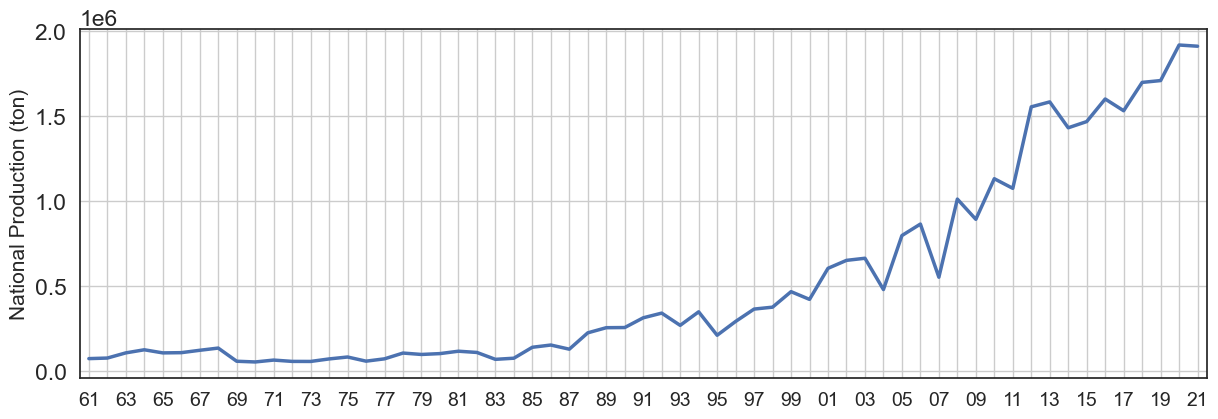

In [36]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
import matplotlib.ticker as ticker
df = pd.read_csv('../data/crop/adm_fao_stat.csv', index_col=0)
sr = df[
    (df['cnt_name'] == 'Burkina Faso') &
    (df['cpc2_name'] == 'Maize (corn)') &
    (df['indicator'] == 'Production')
].set_index('year')['value']
years = sr.index
# Plotting
sns.set(style="white", font_scale=1.5)
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12,4))
sr.plot(ax=ax, legend=None, linewidth=2.5, marker=None)
ax.set_xlim([years.min()-0.5, years.max()+0.5])
ax.set_xticks(years[::2])
ax.set_xticklabels(['%02d'% yr for yr in np.mod(years[::2],100)], fontsize=14)
ax.xaxis.grid(True)
ax.grid(True)
ax.set_xlabel('')
ax.set_ylabel('National Production (ton)', fontsize=15)
tick_spacing = 1
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.tight_layout(pad=0)
plt.show()